 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Oct/2023 00:35:40] "GET /docs/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2023 00:35:41] "GET /flasgger_static/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 00:35:41] "GET /flasgger_static/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 00:35:41] "GET /flasgger_static/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 00:35:41] "GET /flasgger_static/lib/jquery.min.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 00:35:41] "GET /docs.json HTTP/1.1" 200 -
D:\KULIAH DI DEL\DATA SCIENCE\venv_test\project_venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\KULIAH DI DEL\DATA SCIENCE\venv_test\project_venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is dep

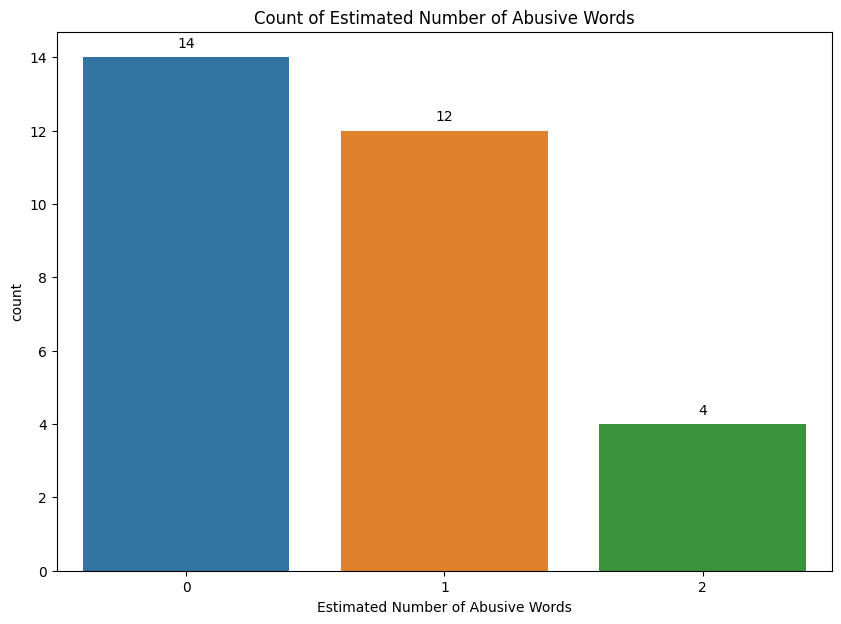

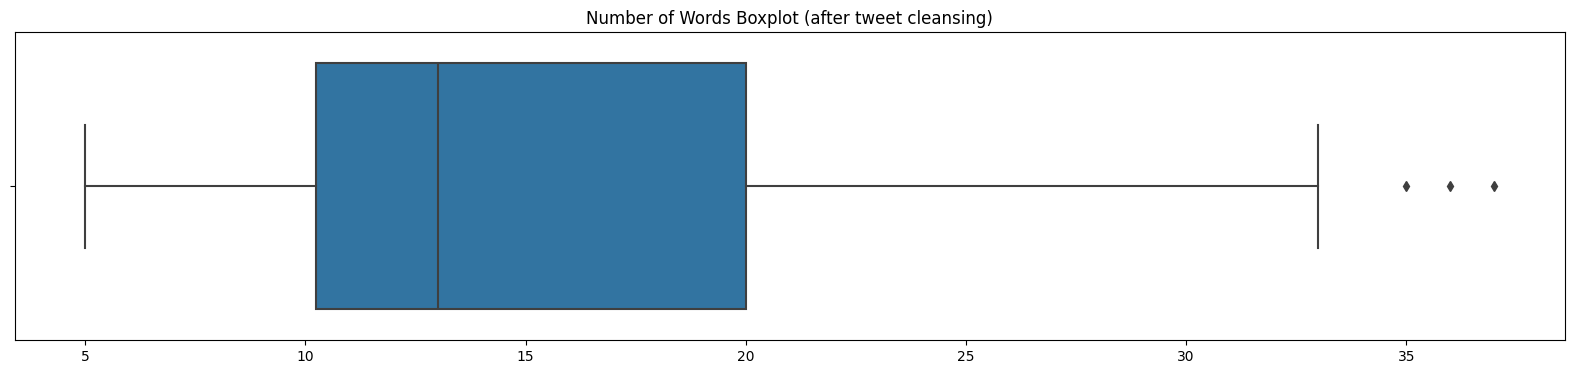

In [1]:
# IMPORT LIBRARIES FOR REGEX, PANDAS, NUMPY, SQLITE3, MATPLOTLIB, SEABORN, AND WARNINGS (TO IGNORE VISUALIZATION RESULT WARNING
import re
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# IMPORT LIBRARY FOR FLASK AND SWAGGER
from flask import Flask, jsonify, request
from flasgger import Swagger, LazyString, LazyJSONEncoder
from flasgger import swag_from

# DEFAULT FLASK AND SWAGGER DEFAULT SETTING
app = Flask(__name__)
app.json_encoder = LazyJSONEncoder
swagger_template = dict(
info = {
    'title': LazyString(lambda: 'API Documentation for Data Processing and Modeling'),
    'version': LazyString(lambda: '1.0.0'),
    'description': LazyString(lambda: 'Dokumentasi API untuk Data Processing dan Modeling'),
    },
    host = LazyString(lambda: request.host)
)
swagger_config = {
    "headers": [],
    "specs": [
        {
            "endpoint": 'docs',
            "route": '/docs.json',
        }
    ],
    "static_url_path": "/flasgger_static",
    "swagger_ui": True,
    "specs_route": "/docs/"
}
swagger = Swagger(app, template=swagger_template,             
                  config=swagger_config)

# IMPORT ABUSIVE.CSV AND NEW_KAMUSALAY.CSV TO PANDAS DATAFRAME (EACH)
df_abusive = pd.read_csv('abusive.csv')
df_kamusalay = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
df_kamusalay.columns=["tidak baku","baku"]

# DEFINE ENDPOINTS: BASIC GET
@swag_from("D:/KULIAH DI DEL/DATA SCIENCE/docs/hello_world_yosef.yml", methods=['GET'])
@app.route('/', methods=['GET'])
def hello_world():
    json_response = {
        'status_code': 200,
        'description': "Menyapa Hello World",
        'data': "Hello World",
    }
    response_data = jsonify(json_response)
    return response_data

# DEFINE ENDPOINTS: POST FOR TEXT PROCESSING FROM TEXT INPUT
@swag_from("D:/KULIAH DI DEL/DATA SCIENCE/docs/text_processing_yosef.yml", methods=['POST'])
@app.route('/text-processing', methods=['POST'])
def text_processing():
    
    text = request.form.get('text')
    
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah diproses",
        'data': re.sub(r'[^a-zA-Z0-9]',' ', text)
    }
    
    response_data = jsonify(json_response)
    return response_data

# DEFINE ENDPOINTS: POST FOR TEXT PROCESSING FROM FILE
@swag_from("D:/KULIAH DI DEL/DATA SCIENCE/docs/file_processing_yosef.yml", methods=['POST'])
@app.route('/text-processing-file', methods=['POST'])
def text_processing_file():
    global post_df_mine
    
    # USING REQUEST TO GET FILE THAT HAS BEEN POSTED FROM API ENDPOINT
    file = request.files.get('file')
    
    # IMPORT FILE OBJECT INTO PANDAS DATAFRAME (YOU CAN SPECIFY NUMBER OF ROWS IMPORTED USING PARAMETER nrows=(integer value) )
    post_df_mine = pd.read_csv(file, encoding='latin-1', nrows=30)
    
    # SET THE TWEET COLUMN ONLY FOR THE DATAFRAME
    post_df_mine = post_df_mine[['Tweet']]
    
    # DROP DUPLICATED TWEETS
    post_df_mine.drop_duplicates(inplace=True)
    
    # CREATE NEW NUMBER OF CHARACTERS (NO_CHAR) COLUMN THAT CONSISTS OF LENGTH OF TWEET CHARACTERS
    post_df_mine['no_char'] = post_df_mine['Tweet'].apply(len)
    
    # CREATE NEW NUMBER OF WORDS (NO_WORDS) COLUMN THAT CONSISTS OF NUMBER OF WORDS OF EACH TWEET
    post_df_mine['no_words'] = post_df_mine['Tweet'].apply(lambda x: len(x.split()))
    
    # CREATE A FUNCTION TO CLEAN DATA FROM ANY NON ALPHA-NUMERIC (AND NON-SPACE) CHARACTERS, AND STRIP IT FROM LEADING/TRAILING SPACES
    def tweet_cleansing(x):
        tweet = x
        cleaned_tweet = re.sub(r'[^a-zA-Z0-9 ]','',tweet).strip()
        return cleaned_tweet
    
    # APPLY THE TWEET_CLEANSING FUNCTION ON TWEET COLUMN, AND CREATE A NEW CLEANED_TWEET COLUMN
    post_df_mine['cleaned_tweet'] = post_df_mine['Tweet'].apply(lambda x: tweet_cleansing(x))
    
    # CREATE NEW NO_CHAR, AND NO_WORDS COLUMNS BASED ON CLEANED_TWEET COLUMN
    post_df_mine['no_char_2'] = post_df_mine['cleaned_tweet'].apply(len)
    post_df_mine['no_words_2'] = post_df_mine['cleaned_tweet'].apply(lambda x: len(x.split()))
    
    # CREATE A FUNCTION TO COUNT NUMBER OF ABUSIVE WORDS FOUND IN A CLEANED TWEET
    def count_abusive(x):
        cleaned_tweet = x
        matched_list = []
        for i in range(len(df_abusive)):
            for j in x.split():
                word = df_abusive['ABUSIVE'].iloc[i]
                if word==j.lower():
                    matched_list.append(word)
        return len(matched_list)
    
    # APPLY THE FUNCTION TO COUNT ABUSIVE WORDS, AND CREATE A NEW COLUMN BASED OFF OF IT
    post_df_mine['estimated_no_abs_words'] = post_df_mine['cleaned_tweet'].apply(lambda x: count_abusive(x))
    
    # CONNECT / CREATE NEW DATABASE AND CREATE NEW TABLE CONSISTING LISTED TABLES
    conn = sqlite3.connect('my_database_project.db')
    q_create_table = """
    create table post_df_mine (Tweet varchar(255), no_char int, no_words int, cleaned_tweet varchar(255), no_char_2 int, no_words_2 int);
    """
    conn.execute(q_create_table)
    conn.commit()
    
    
    # DO ITERATIONS TO INSERT DATA (EACH ROW) FROM FINAL DATAFRAME (POST_DF)
    for i in range(len(post_df_mine)):
        tweet = post_df_mine['Tweet'].iloc[i]
        no_char = int(post_df_mine['no_char'].iloc[i])
        no_words = int(post_df_mine['no_words'].iloc[i])
        cleaned_tweet = post_df_mine['cleaned_tweet'].iloc[i]
        no_char_2 = int(post_df_mine['no_char_2'].iloc[i])
        no_words_2 = int(post_df_mine['no_words_2'].iloc[i])
    
        q_insertion = "insert into post_df_mine (Tweet, no_char, no_words, cleaned_tweet, no_char_2, no_words_2) values (?,?,?,?,?,?)"
        conn.execute(q_insertion,(tweet,no_char,no_words,cleaned_tweet,no_char_2,no_words_2))
        conn.commit()
        
    conn.close()
    
    # VISUALIZE THE NUMBER OF ABUSIVE WORDS USING BARPLOT (COUNTPLOT)
    plt.figure(figsize=(10,7))
    countplot = sns.countplot(data=post_df_mine, x="estimated_no_abs_words")
    for p in countplot.patches:
        countplot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center'
                            , va = 'center', xytext = (0, 10), textcoords = 'offset points')

    %matplotlib inline
    warnings.filterwarnings('ignore', category=FutureWarning)

    plt.title('Count of Estimated Number of Abusive Words')
    plt.xlabel('Estimated Number of Abusive Words')
    plt.savefig('new_countplot.jpeg')
    
    plt.figure(figsize=(20,4))
    boxplot = sns.boxplot(data=post_df_mine, x="no_words_2")

    print()
    
    # VISUALIZE THE NUMBER OF WORDS USING BOXPLOT
    %matplotlib inline
    warnings.filterwarnings('ignore', category=FutureWarning)

    plt.title('Number of Words Boxplot (after tweet cleansing)')
    plt.xlabel('')
    plt.savefig('new_boxplot.jpeg')
    
    # OUTPUT THE RESULT IN JSON FORMAT
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah diproses",
        'data': list(post_df_mine['cleaned_tweet'])
    }
    
    response_data = jsonify(json_response)
    return response_data

if __name__ == "__main__":
    app.run()

In [2]:
post_df_mine

,Tweet,no_char,no_words,cleaned_tweet,no_char_2,no_words_2,estimated_no_abs_words
0,- disaat semua cowok berusaha melacak perhatia...,138,25,disaat semua cowok berusaha melacak perhatian ...,127,21,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,120,21,RT USER USER siapa yang telat ngasih tau elued...,117,21,1
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",254,37,41 Kadang aku berfikir kenapa aku tetap percay...,247,37,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,75,14,USER USER AKU ITU AKUnnKU TAU MATAMU SIPIT TAP...,72,14,1
4,USER USER Kaum cebong kapir udah keliatan dong...,89,14,USER USER Kaum cebong kapir udah keliatan dong...,88,14,2
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,73,6,USER Ya bani taplak dkk xf0x9fx98x84xf0x9fx98x...,60,6,2
6,deklarasi pilkada 2018 aman dan anti hoax warg...,64,11,deklarasi pilkada 2018 aman dan anti hoax warg...,64,11,0
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,129,20,Gue baru aja kelar rewatch Aldnoah Zero paling...,123,20,1
8,Nah admin belanja satu lagi port terbaik nak m...,231,42,Nah admin belanja satu lagi port terbaik nak m...,211,36,0
9,USER Enak lg klo smbil ngewe',29,6,USER Enak lg klo smbil ngewe,28,6,1


In [5]:
conn = sqlite3.connect('my_database_project.db')
query_result = conn.execute('select count(*) from post_df_mine')
result = query_result.fetchall()
result

[(30,)]

In [6]:
query_result2 = conn.execute("PRAGMA table_info('post_df_mine')")
result_2 = query_result2.fetchall()
result_2

[(0, 'Tweet', 'varchar(255)', 0, None, 0),
 (1, 'no_char', 'INT', 0, None, 0),
 (2, 'no_words', 'INT', 0, None, 0),
 (3, 'cleaned_tweet', 'varchar(255)', 0, None, 0),
 (4, 'no_char_2', 'INT', 0, None, 0),
 (5, 'no_words_2', 'INT', 0, None, 0)]

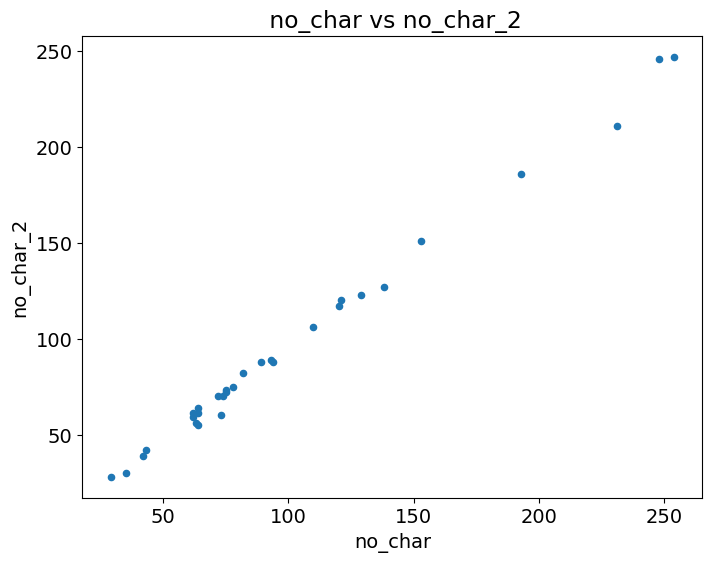

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'figure.figsize': (8,6)})
post_df_mine.plot(kind='scatter', x='no_char', y='no_char_2', 
    title=' no_char vs no_char_2');

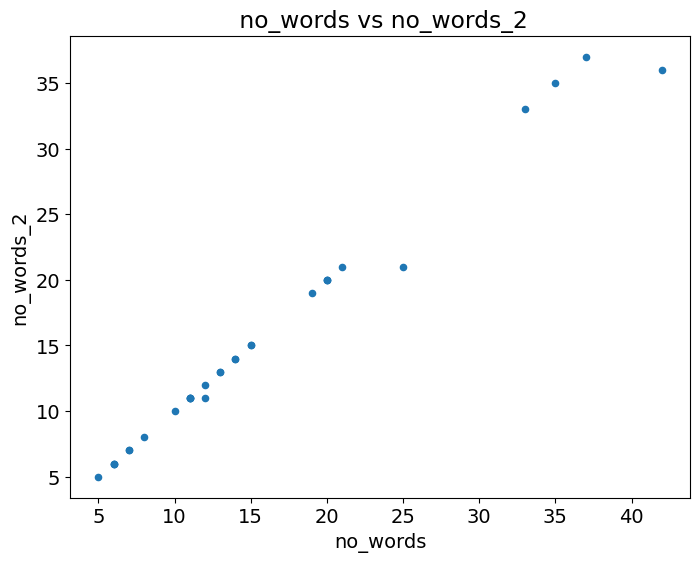

In [22]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'figure.figsize': (8,6)})
post_df_mine.plot(kind='scatter', x='no_words', y='no_words_2', 
    title=' no_words vs no_words_2');

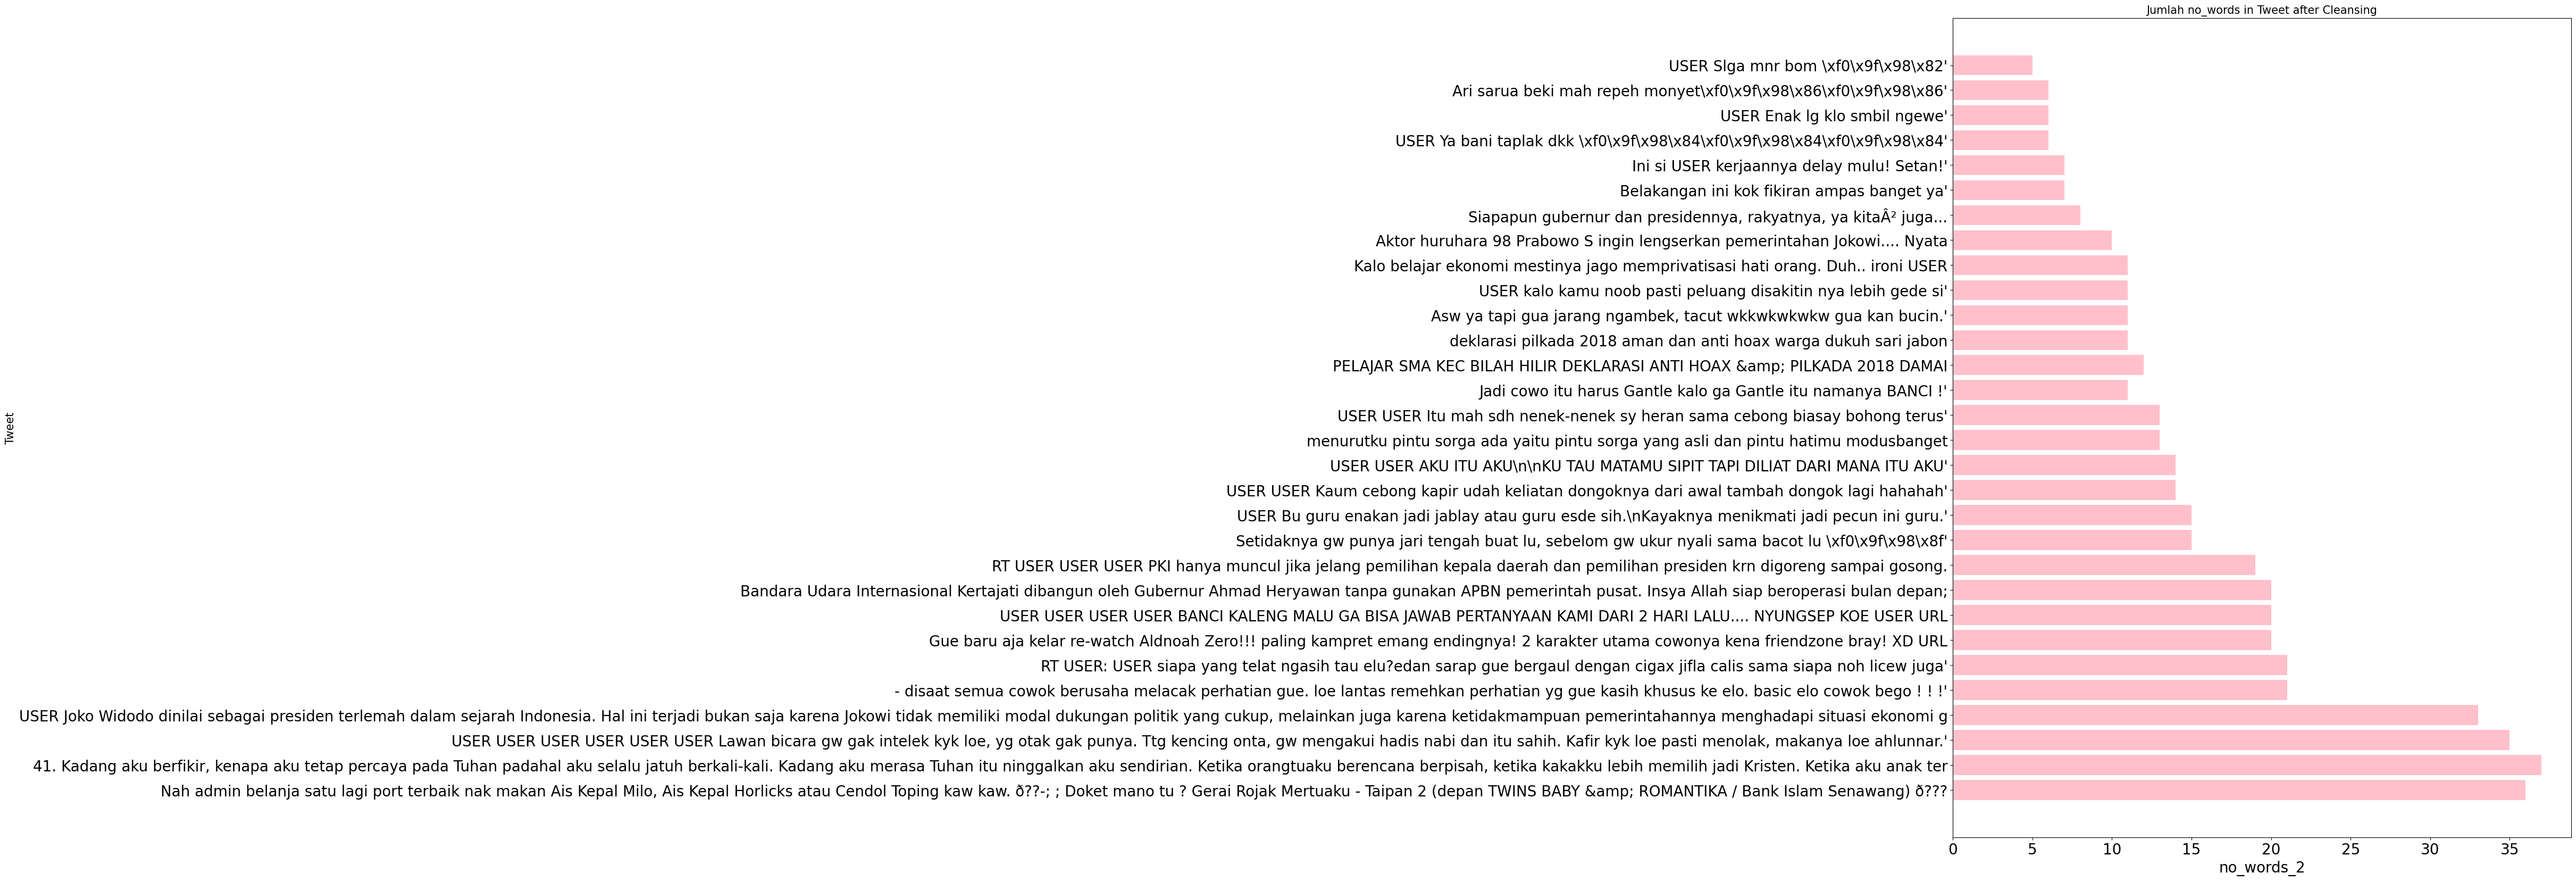

In [39]:
post_df_sorted = post_df_mine.sort_values(by='no_words', ascending=False)
fig = plt.figure(figsize=(15,20))
plt.barh(post_df_sorted['Tweet'], post_df_sorted['no_words_2'], color='pink')
plt.title('Jumlah no_words in Tweet after Cleansing', fontsize=15)
plt.xlabel('no_words_2', fontsize=20)
plt.ylabel('Tweet', fontsize=15)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

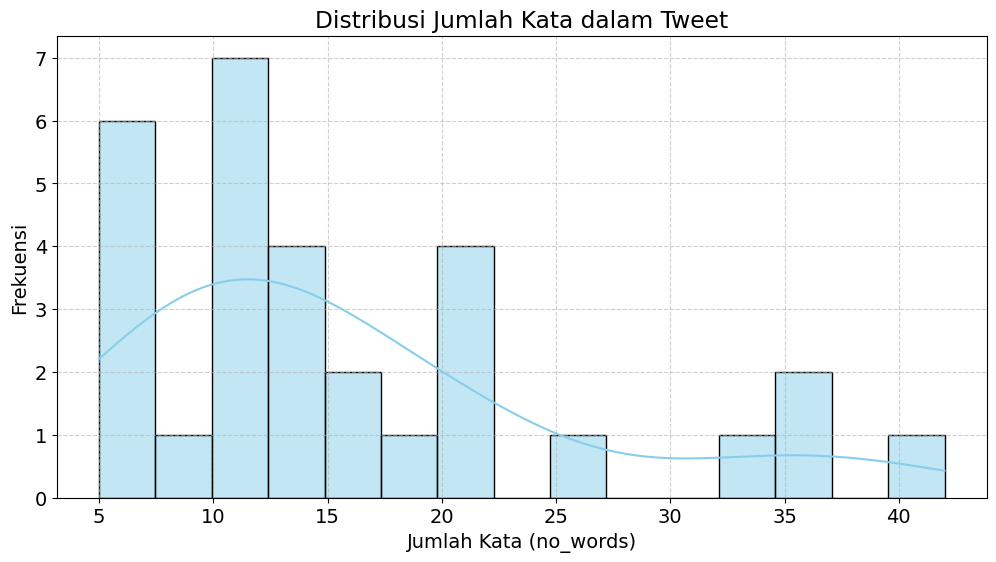

In [41]:
plt.figure(figsize=(12, 6))
sns.histplot(data=post_df_mine, x='no_words', bins=15, kde=True, color='skyblue')
plt.xlabel('Jumlah Kata (no_words)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Jumlah Kata dalam Tweet')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


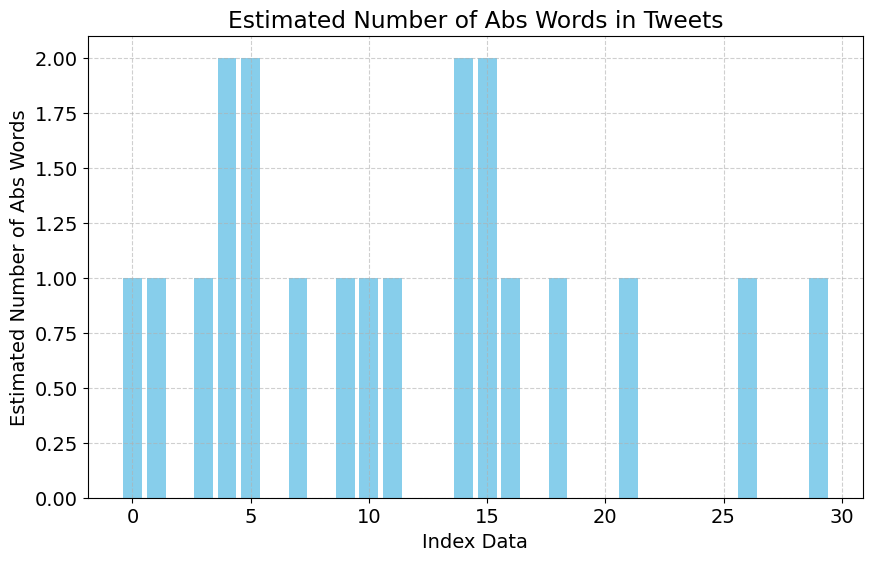

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(post_df_mine.index, post_df_mine['estimated_no_abs_words'], color='skyblue')
plt.xlabel('Index Data')
plt.ylabel('Estimated Number of Abs Words')
plt.title('Estimated Number of Abs Words in Tweets')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
